# Проект: классификация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Подгружаем данные

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### исследуем данные на предмет пропусков

In [4]:
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### исследуем данные на предмет пропусков более подробно

In [5]:
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Преобразуем признак _balance_ в вещественное число (float)

In [6]:
def change_balance(x):
    if isinstance(x, (str)):
        x = x.replace(' ', '')
        x = x.replace('$', '')
        x = x.replace(',', '.')
        return float(x)
    else:
        return float(x)
df['balance'] = df['balance'].apply(lambda x: change_balance(x))    

### обработаем пропуски в признаки _balance_

In [7]:
df['balance'] = df['balance'].fillna(df['balance'].median())

### Обработаем пропуски в категориальных признаках: _job_ и _education_

In [8]:
df['education'].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

In [9]:
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [10]:
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

In [11]:
df['education'].value_counts()

education
secondary    5973
tertiary     3689
primary      1500
Name: count, dtype: int64

In [12]:
df['job'].value_counts()

job
management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: count, dtype: int64

In [13]:
df[['education', 'job']].value_counts(normalize=True)

education  job          
tertiary   management       0.195933
secondary  technician       0.112973
           blue-collar      0.107687
           admin.           0.100699
           services         0.070507
primary    blue-collar      0.062175
tertiary   technician       0.046676
secondary  management       0.033686
           retired          0.032342
primary    retired          0.024816
secondary  student          0.022935
tertiary   self-employed    0.020606
secondary  unemployed       0.019441
tertiary   admin.           0.015051
secondary  entrepreneur     0.013886
           self-employed    0.013170
primary    housemaid        0.012901
tertiary   retired          0.012543
           entrepreneur     0.011826
secondary  housemaid        0.007794
tertiary   unemployed       0.007526
primary    services         0.007436
tertiary   student          0.007436
primary    management       0.006540
           unemployed       0.005017
tertiary   services         0.004748
           bl

### Удалим все выбросы для признака _balance_

In [14]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    print(lower_bound, upper_bound)
    return cleaned
df = outliers_iqr_mod(df, 'balance')

-2241.0 4063.0


## Часть 2:  Разведывательный анализ

### Проверим сбалансированность ключевого признака

In [15]:
df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

### Описательная статистика

In [16]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Возраст: min = 18, max = 95, mean = 41.  
Баланс: min = -2049(долг), max = 4063, mean = 808.

### Описательные статистики для категориальных переменных

In [17]:
df.describe(include=[object]) 

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Для признаков _default_ (98%), _loan_ (86%) большинство строк с единственным значением.  
Для признака _poutcome_ большинство значений (74%) _unknown_.  

### Исследуем целевой признак

In [18]:
# Отношение маркетинговых компаний и депозита
df[['poutcome', 'deposit']].value_counts()

poutcome  deposit
unknown   no         4562
          yes        3008
success   yes         861
failure   no          562
          yes         547
other     yes         265
          no          216
success   no           84
Name: count, dtype: int64

In [19]:
# Месяц, в котором чаще всего отказывались от предложения открыть депозит
df[df['deposit'] == 'no']['month'].value_counts()

month
may    1776
jul     836
aug     775
jun     606
nov     456
feb     323
apr     317
jan     194
oct      62
sep      46
mar      24
dec       9
Name: count, dtype: int64

### Создадим признак возрастных групп

In [20]:
def age_group(x):
    if x < 30:
        return 0
    elif x < 40:
        return 1
    elif x < 50:
        return 2
    elif x < 60:
        return 3
    else:
        return 4
df['age_group'] = df['age'].apply(lambda x: age_group(x))
df[['age_group', 'deposit']].value_counts()

age_group  deposit
1          no         2245
           yes        1716
2          no         1444
3          no          984
2          yes         938
0          yes         861
3          yes         670
0          no          594
4          yes         496
           no          157
Name: count, dtype: int64

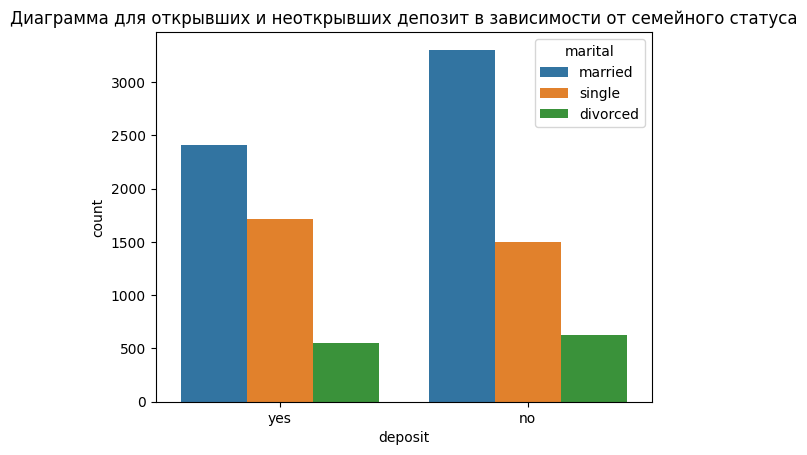

In [21]:
pl1 = sns.countplot(x=df["deposit"], hue=df['marital'])
pl1.set_title("Диаграмма для открывших и неоткрывших депозит в зависимости от семейного статуса")
plt.show()

Для семейного статуса _married_ преобладает целевой признак _no_.

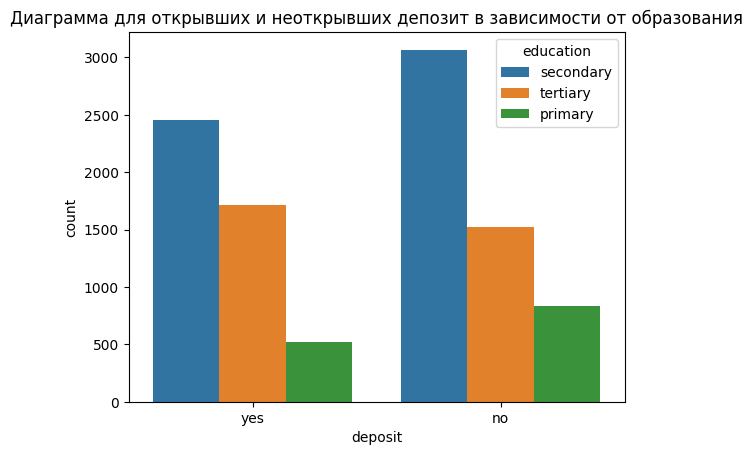

In [22]:
pl2 = sns.countplot(x=df["deposit"], hue=df['education'])
pl2.set_title("Диаграмма для открывших и неоткрывших депозит в зависимости от образования")
plt.show()

Для уровня образования _secondaty_ и _primary_ преобладает целевой признак _no_.  

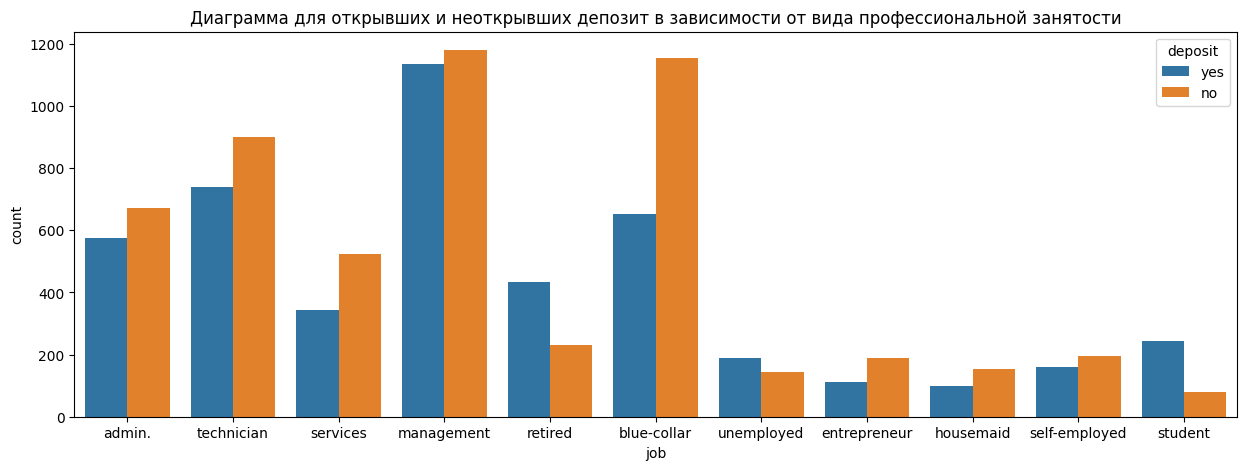

In [23]:
plt.figure(figsize=[15,5])
pl3 = sns.countplot(x=df["job"], hue=df['deposit'])
pl3.set_title("Диаграмма для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости")
plt.show()

Для большинства вид профессиональной деятельности преобладает целевой признак _no_, кроме _retired_, _unemployed_, _student_ (безработные).

In [24]:
# Сводная таблица, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
table = pd.pivot_table(df[df['deposit'] == 'yes'],values=['age'], index=['marital', 'education'], aggfunc=['count'])
table

count
                     age
marital  education      
divorced primary      96
         secondary   283
         tertiary    174
married  primary     339
         secondary  1289
         tertiary    784
single   primary      82
         secondary   879
         tertiary    755

Наиболее многочисленная группа на пересечении _married_, _secondary_.

## Часть 3: преобразование данных

### Преобразуем уровни образования

In [25]:
le = LabelEncoder()
le_education = le.fit_transform(df['education'])
df['education'] = le_education

### Преобразуем бинарные переменные

In [26]:
def binary(df, columns):
    """Create binary features

    Args:
        df (DataFrame): DataFrame
        columns (list): Changeable columns
    """
    for column in columns:
        df[column] = df[column].apply(lambda x: 1 if x == 'yes' else 0)    

binary(df, ['deposit', 'default', 'housing', 'loan'])

### Создадим дамми-переменные

In [27]:
df_dummies = pd.get_dummies(df[['job', 'marital', 'contact', 'month', 'poutcome']], columns=['job', 'marital', 'contact', 'month', 'poutcome'])
df = pd.concat([df, df_dummies], axis=1)
df = df.drop(['job', 'marital', 'contact', 'month', 'poutcome', 'age'], axis=1)


### Построим корреляционную матрицу

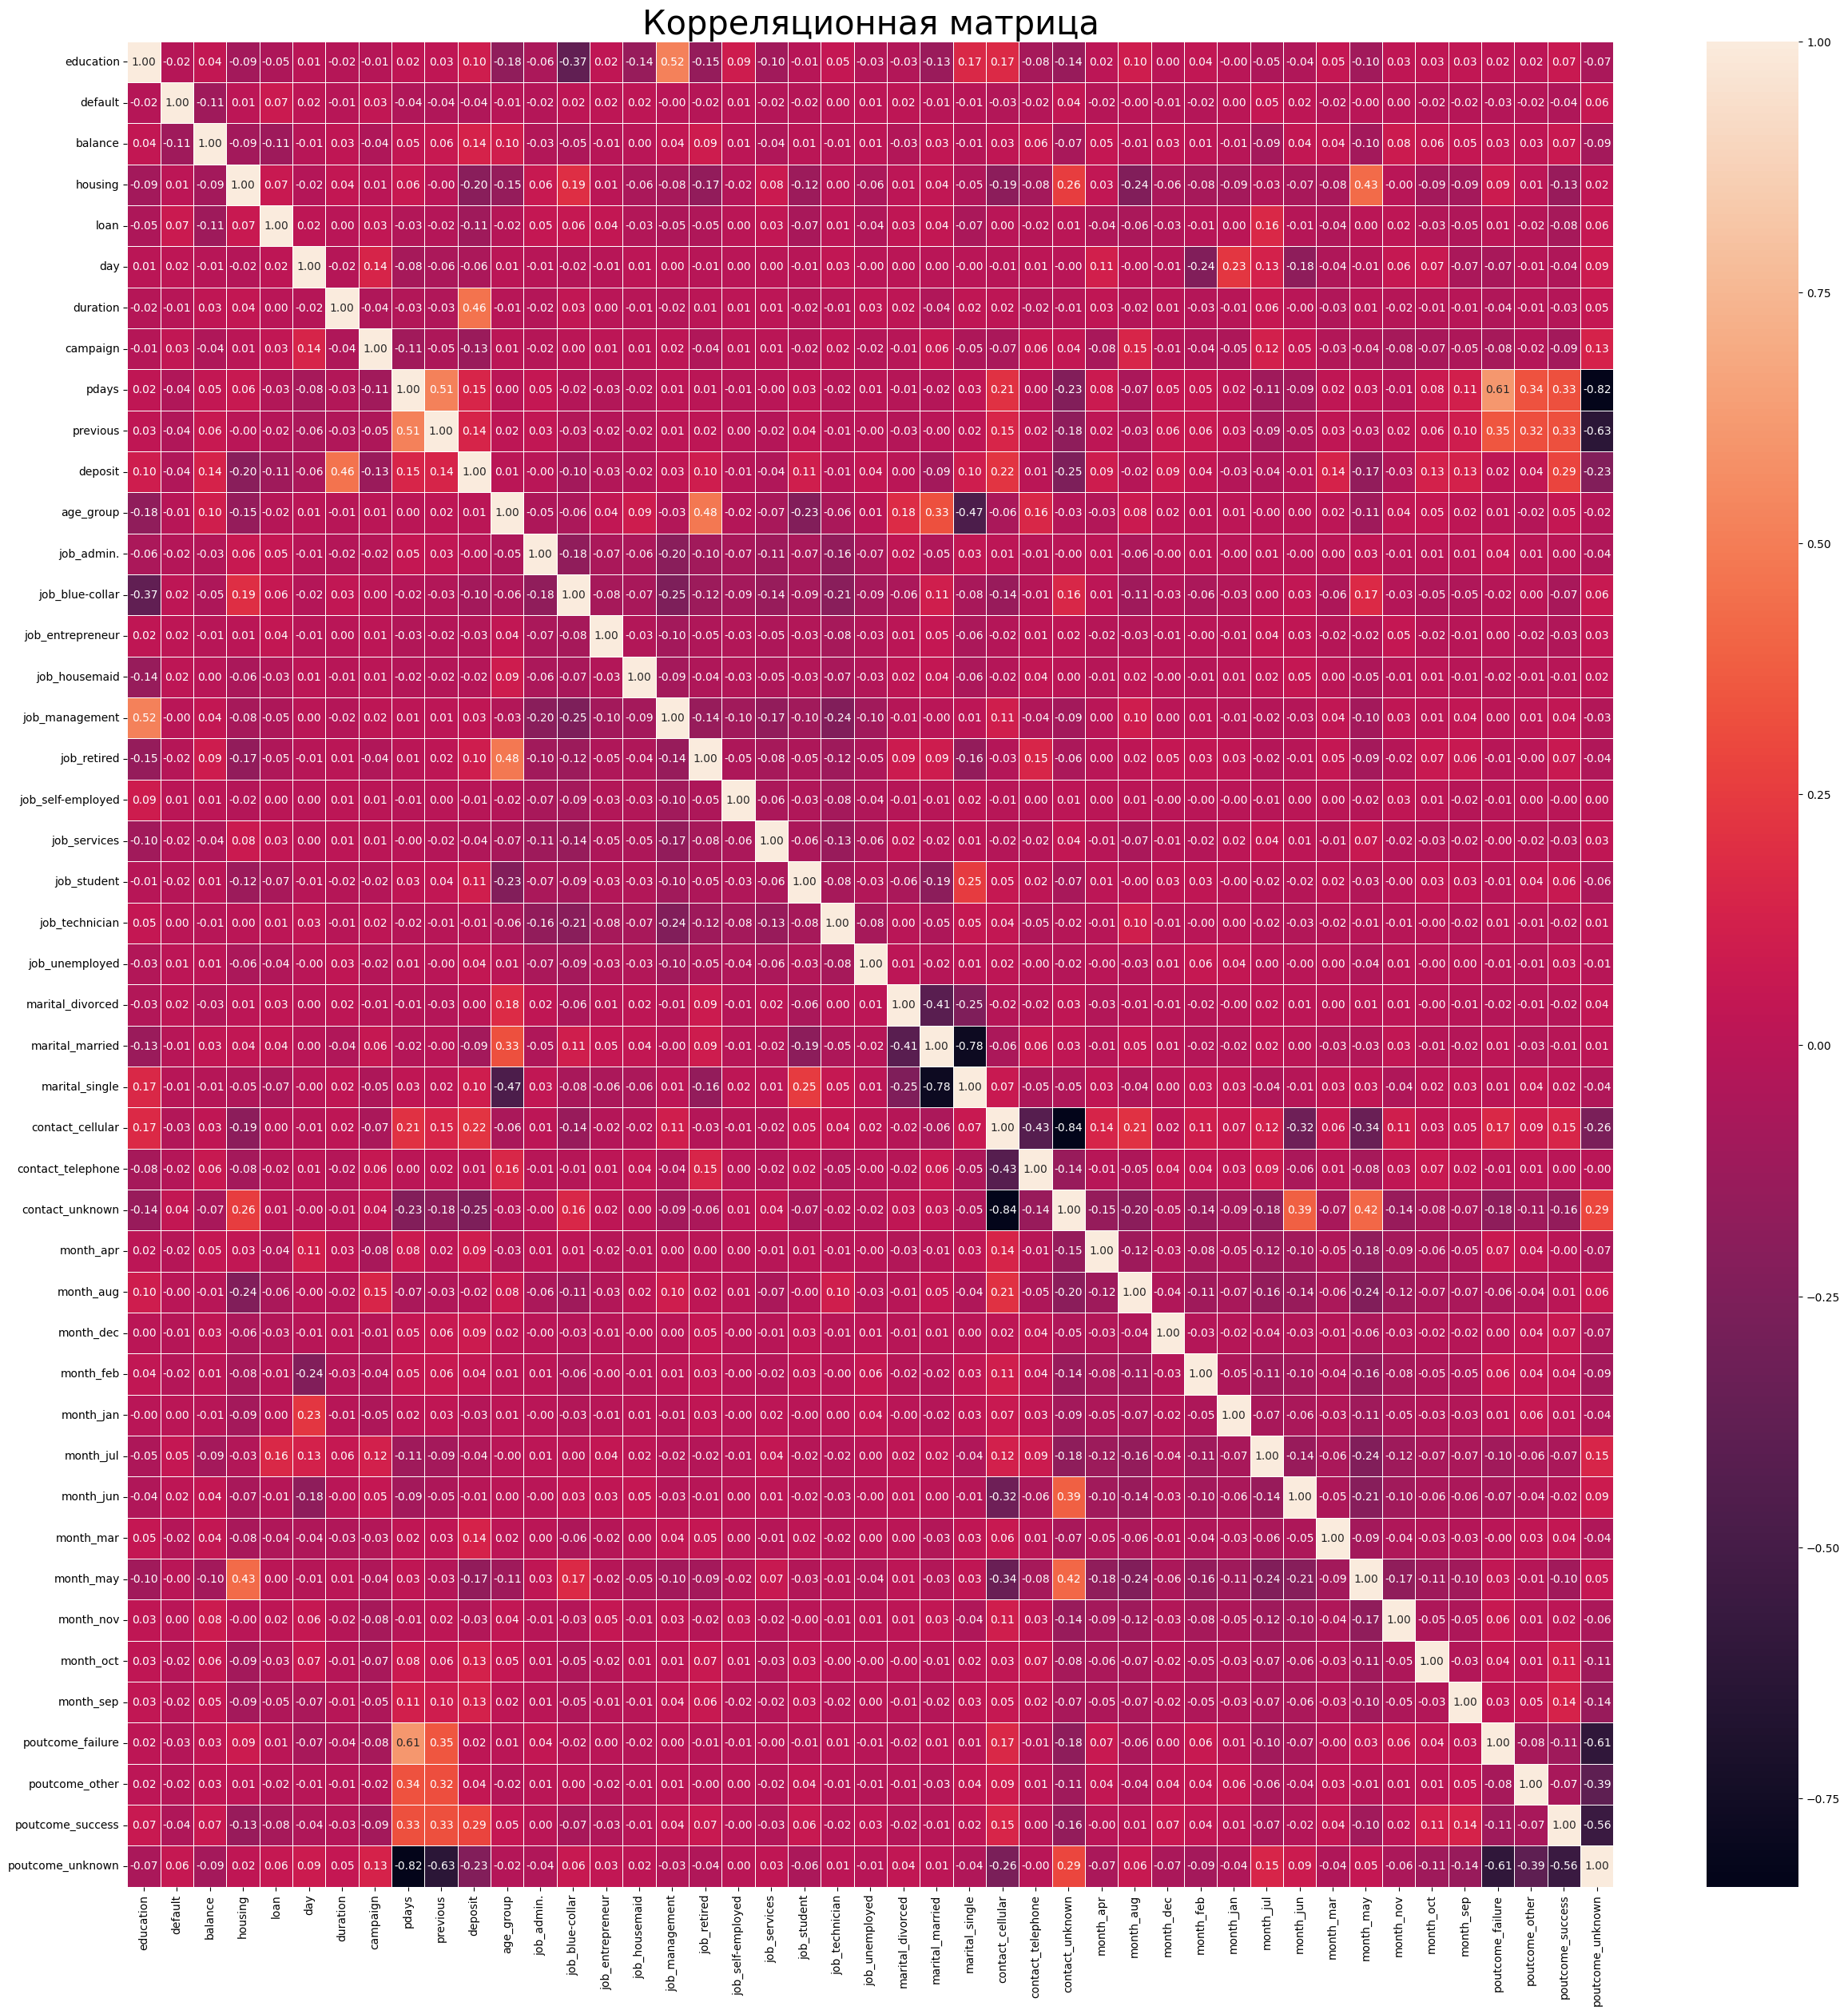

In [33]:
plt.figure(figsize=[30,30])
ax = sns.heatmap(df.corr(), annot=True, linewidth=.5, fmt='.2f')
ax.set_title("Корреляционная матрица", size=30)
plt.show()

Признаки с высокой корреляцией (значение корреляции выше 0.9 или ниже -0.9) отсутствуют.

### Выделим целевой признак и разобьем данные

In [ ]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Отберем 15 наиболее подходящих признаков

In [ ]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
col_skb = selector.get_feature_names_out()
col_skb

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Нормализуем данные

In [ ]:
mm_scaler = preprocessing.MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train[col_skb])
X_test_mm = mm_scaler.fit_transform(X_test[col_skb])

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Логистическая регрессия

In [ ]:
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
log_reg.fit(X_train_mm, y_train)
y_train_predict = log_reg.predict(X_train_mm)
y_test_predict = log_reg.predict(X_test_mm)
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.81      0.82      0.81      3335
weighted avg       0.82      0.82      0.82      3335



### Решающие деревья

In [ ]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6, 
    random_state=42
)
dt.fit(X_train_mm, y_train)
y_train_predict_dt = dt.predict(X_train_mm)
y_test_predict_dt = dt.predict(X_test_mm)
print(metrics.classification_report(y_test, y_test_predict_dt))
print(metrics.classification_report(y_train, y_train_predict_dt))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1790
           1       0.77      0.82      0.79      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3634
           1       0.82      0.77      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.82      6770



### Подберем оптимальные параметры с помощью gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_mm, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_mm, y_test)))
y_test_pred = grid_search.predict(X_test_mm)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 391 ms
Wall time: 2.35 s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Случайный лес

In [ ]:
rfr = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
    )
rfr.fit(X_train_mm, y_train)
y_train_rfr = rfr.predict(X_train_mm)
y_test_rfr = rfr.predict(X_test_mm)
print(metrics.classification_report(y_test, y_test_rfr))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1790
           1       0.76      0.89      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Градиентный бустинг

In [ ]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
    )

gb.fit(X_train_mm, y_train)
y_train_gb = gb.predict(X_train_mm)
y_test_gb = gb.predict(X_test_mm)
print(metrics.classification_report(y_test, y_test_gb))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1790
           1       0.76      0.88      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Объединим модели используя стекинг

In [ ]:
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=6, 
        random_state=42
        )
    ),
    ('gb',  ensemble.GradientBoostingClassifier(
        learning_rate = 0.05,
        n_estimators = 300,
        min_samples_leaf = 5,
        max_depth = 5,
        random_state = 42
        )
    )
]

# Создаем объект класса стекинг
sr = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
        solver='sag',
        random_state=42, 
        max_iter=1000
        )
    )

sr.fit(X_train_mm, y_train)
y_train_sr = sr.predict(X_train_mm)
y_test_sr = sr.predict(X_test_mm)
print(metrics.classification_report(y_test, y_test_sr))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1790
           1       0.77      0.87      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Оптимизируем гиперпараметры с помощью Optuna

In [ ]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)


  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_mm, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test_mm))

  return score

In [ ]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-07-09 13:05:16,582] A new study created in memory with name: RandomForestClassifier
[I 2024-07-09 13:05:17,174] Trial 0 finished with value: 0.8188319427890346 and parameters: {'n_estimators': 155, 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8188319427890346.
[I 2024-07-09 13:05:17,565] Trial 1 finished with value: 0.8165574746873139 and parameters: {'n_estimators': 122, 'max_depth': 30, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8188319427890346.
[I 2024-07-09 13:05:18,360] Trial 2 finished with value: 0.8199940493900625 and parameters: {'n_estimators': 191, 'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8199940493900625.
[I 2024-07-09 13:05:18,824] Trial 3 finished with value: 0.8188319427890346 and parameters: {'n_estimators': 132, 'max_depth': 16, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8199940493900625.
[I 2024-07-09 13:05:19,452] Trial 4 finished with value: 0.8218116805721096 and parameters: {'n

CPU times: total: 11.9 s
Wall time: 12.1 s


In [ ]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 198, 'max_depth': 11, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.82


In [ ]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_mm, y_train)
y_train_pred = model.predict(X_train_mm)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_mm, y_test)))
y_test_pred = model.predict(X_test_mm)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.82


In [ ]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2024-07-09 13:06:20,687] Trial 20 finished with value: 0.8205891103838143 and parameters: {'n_estimators': 164, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.8218116805721096.
[I 2024-07-09 13:06:21,327] Trial 21 finished with value: 0.8192914557904138 and parameters: {'n_estimators': 161, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.8218116805721096.
[I 2024-07-09 13:06:21,862] Trial 22 finished with value: 0.8196915776986952 and parameters: {'n_estimators': 146, 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.8218116805721096.
[I 2024-07-09 13:06:22,448] Trial 23 finished with value: 0.8173134328358209 and parameters: {'n_estimators': 166, 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 4 with value: 0.8218116805721096.
[I 2024-07-09 13:06:23,124] Trial 24 finished with value: 0.8199940493900625 and parameters: {'n_estimators': 173, 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 4 with value: 

CPU times: total: 5.28 s
Wall time: 5.3 s


In [ ]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_mm, y_train)
y_train_pred = model.predict(X_train_mm)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_mm, y_test)))
y_test_pred = model.predict(X_test_mm)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.82


In [ ]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [ ]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")